In [43]:
import re
import random
import numpy as np
import urllib
import gensim
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from IPython import display

In [44]:
# Use the URL to obtain the corpus from the web 
url = 'https://cogcomp.seas.upenn.edu/Data/QA/QC/train_5500.label'

try:
    url_response = urllib.request.urlopen(url) 
except urllib.error.HTTPError as e:
    e.msg += ' ' + url
    raise

In [45]:
# Obtain raw text from the given URL
# Decode the bytes using UTF-8 format
# Use the keyword 'ignore' for decoding
raw_text = url_response.read().decode('utf8', 'ignore')

In [46]:
print(type(raw_text))
raw_text[:100]

<class 'str'>


'DESC:manner How did serfdom develop in and then leave Russia ?\nENTY:cremat What films featured the c'

# Data Preprocessing

Split the tag from the dataset

In [47]:
# Remove the whitespace in the beginning and the end
# Split the string and convert it into a list of questions
ques_list = raw_text.strip().split('\n')

# Show the last five samples
for q in ques_list[-5:]: 
    print(q) 

print(f'Total tagged questions: {len(ques_list)}')

ENTY:other What 's the shape of a camel 's spine ?
ENTY:currency What type of currency is used in China ?
NUM:temp What is the temperature today ?
NUM:temp What is the temperature for cooking ?
ENTY:currency What currency is used in Australia ?
Total tagged questions: 5452


In [48]:
# Use one sample in the question list to show the data processing
rand_idx = random.randint(0, len(ques_list))
sample = ques_list[rand_idx]
print(sample)

split_sample = sample.split(':')
print(split_sample)

mark, ques = split_sample[0], split_sample[1][:-1] # Remove the question mark
print([ques, mark])

DESC:manner How do you write a correct critical analysis of a poem ?
['DESC', 'manner How do you write a correct critical analysis of a poem ?']
['manner How do you write a correct critical analysis of a poem ', 'DESC']


In [49]:
# Data processing on the whole dataset
tagged_ques_list = [[q.split(':')[1][:-1], q.split(':')[0]] for q in ques_list]

In [50]:
assert len(tagged_ques_list) == len(ques_list), "Different length after data processing"

In [51]:
ques, tags = list(zip(*tagged_ques_list)) # Split the questions and the tags
ques, tags = list(ques), list(tags) # Convert from tuple to list

print(ques[10:15])
print(tags[10:15])

['date When was Ozzy Osbourne born ', 'reason Why do heavier objects travel downhill faster ', 'ind Who was The Pride of the Yankees ', 'ind Who killed Gandhi ', 'event What is considered the costliest disaster the insurance industry has ever faced ']
['NUM', 'DESC', 'HUM', 'HUM', 'ENTY']


Number masking for search space reduction

In [52]:
for i, q in enumerate(ques):
    ques[i] = re.sub('\d', '#', q).split()

In [53]:
# Extract all words from the all questions
flatten = lambda l: [item for sublist in l for item in sublist]
vocab = list(set(flatten(ques)))

In [54]:
print(f'Total words: {len(vocab)}')
print(vocab[:10])
print(f'Total tags: {len(set(tags))}')
print(set(tags))

Total words: 9125
['Herculoids', 'Dennis', 'Panther', 'seed', 'Younger', 'astronaut', 'audio', 'assassinated', 'node', 'Thanksgiving']
Total tags: 6
{'ENTY', 'NUM', 'LOC', 'DESC', 'ABBR', 'HUM'}


In [55]:
word2index = {'<P>':0, '<U>':1}
init_len = len(word2index)
word2index.update({w:(i + init_len) for i, w in enumerate(vocab)})
index2word = {i:w for w, i in word2index.items()}

In [56]:
tag2index = {t:i for i, t in enumerate(set(tags))}
index2tag = {i:t for t, i in tag2index.items()}
print(tag2index)
print(index2tag)

{'ENTY': 0, 'NUM': 1, 'LOC': 2, 'DESC': 3, 'ABBR': 4, 'HUM': 5}
{0: 'ENTY', 1: 'NUM', 2: 'LOC', 3: 'DESC', 4: 'ABBR', 5: 'HUM'}


Split dataset after tensorization

In [57]:
USE_CUDA = torch.cuda.is_available()
gpus = [0]
torch.cuda.set_device(gpus[0])

FloatTensor = torch.cuda.FloatTensor if USE_CUDA else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if USE_CUDA else torch.LongTensor
ByteTensor = torch.cuda.ByteTensor if USE_CUDA else torch.ByteTensor

In [58]:
def prepare_sequence(seq, to_index):
    idxs = list(map(lambda w: to_index[w] if to_index.get(w) is not None else to_index["<U>"], seq))
    return Variable(LongTensor(idxs))

def prepare_tag(tag, tag2index):
    return Variable(LongTensor([tag2index[tag]]))

In [59]:
ques_tensor, tags_tensor = [], []
for pair in zip(ques, tags):
    ques_tensor.append(prepare_sequence(pair[0], word2index).view(1, -1))
    tags_tensor.append(prepare_tag(pair[1], tag2index).view(1, -1))

ques_tags_tensor = list(zip(ques_tensor, tags_tensor))

In [60]:
def spilt_data(dataset, training_ratio=0.9):
    random.shuffle(dataset)
    split_index = int(len(dataset) * training_ratio)
    return dataset[:split_index], dataset[split_index:]

In [61]:
train_data, test_data = spilt_data(ques_tags_tensor)
print(len(train_data))
print(train_data[:10])
print(len(test_data))
print(test_data[:10])

4906
[(tensor([[3126, 1282, 1518,  391, 6893, 7210, 6375, 5878, 3885, 8312, 1810]],
       device='cuda:0'), tensor([[5]], device='cuda:0')), (tensor([[4758, 6562, 4682, 6631, 3081, 8294, 1174, 3119, 1926]],
       device='cuda:0'), tensor([[5]], device='cuda:0')), (tensor([[1341, 1282,  990, 4682, 4333, 3556, 5839, 6941,  544, 8452, 5434]],
       device='cuda:0'), tensor([[0]], device='cuda:0')), (tensor([[5933, 3080, 5588, 4682, 4696, 1174, 4682, 9017, 7988, 8201]],
       device='cuda:0'), tensor([[2]], device='cuda:0')), (tensor([[6849, 1282, 3546, 5597, 4396, 8452, 2342, 3255,  273, 1039, 1174, 4682,
         1851, 3536]], device='cuda:0'), tensor([[2]], device='cuda:0')), (tensor([[4758, 6492,  990, 4682, 4754, 1894, 8291]], device='cuda:0'), tensor([[5]], device='cuda:0')), (tensor([[4758, 1282,  990, 4046, 1110, 8893, 8110, 2342]], device='cuda:0'), tensor([[5]], device='cuda:0')), (tensor([[5933, 1282, 7258, 1174, 7782, 4826, 4682, 2306, 1174, 5246,  264, 4682,
         2688,

# Batch formalization and sampling

In [62]:
def get_batch(batch_size, train_data):
    random.shuffle(train_data)
    sindex = 0
    eindex = batch_size
    while eindex < len(train_data):
        batch = train_data[sindex: eindex]
        temp = eindex
        eindex = eindex + batch_size
        sindex = temp
        yield batch
    
    if eindex >= len(train_data):
        batch = train_data[sindex:]
        yield batch

In [63]:
ques_max_leng = max([q.size(1) for q in ques_tensor])
ques_max_leng

37

In [64]:
def formalize_batch(batch, max_length=ques_max_leng):
    """
    # Unify all ques tensor into a (1 x max_lengt) size, then stack them up
    # into a (batch_size X max_lengt) tensor
    """
    ques, tags = zip(*batch) 

    ques_tensor = []
    for q in ques:
        if q.size(1) < max_length:
        # Filling '<P>' at the end until len(ques_tensor) == ques_max_length
            reconst_tensor = torch.cat([q, Variable(LongTensor([word2index['<P>']] 
                                            * (ques_max_leng - q.size(1)))).view(1, -1)], 1)
            ques_tensor.append(reconst_tensor)
        else:
            # Or add the tensor directly when it is has the maximum length
            ques_tensor.append(q) 
    
    # Package all tensor into a tensor (1, N) from (N, )
    return torch.cat(ques_tensor), torch.cat(tags).view(-1)

# Build the model

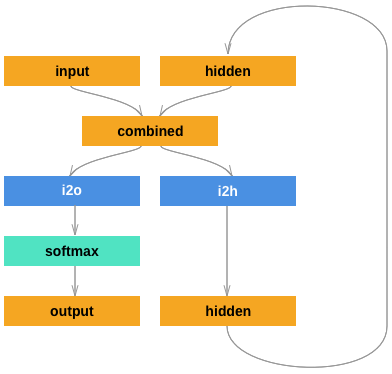

In [65]:
display.Image('imgs/rnn_text_classifier.png')

In [106]:
# Hyper parameters
EPOCH = 10
BATCH_SIZE = 22
EMBED_SIZE = 128
HIDDEN_SIZE = 256
LR = 0.001

A quick overview on the data flowing process in the RNN model

In [93]:
q_t, t_t = formalize_batch(train_data[BATCH_SIZE:BATCH_SIZE * 2], ques_max_leng)
q_t.shape

torch.Size([223, 37])

In [94]:
hidden = torch.zeros(BATCH_SIZE, HIDDEN_SIZE, device='cuda')
hidden.shape

torch.Size([223, 256])

In [95]:
combined = torch.cat((q_t, hidden), 1)
combined.shape

torch.Size([223, 293])

In [96]:
i2h = nn.Linear(ques_max_leng + HIDDEN_SIZE, HIDDEN_SIZE, device='cuda')
i2o = nn.Linear(ques_max_leng + HIDDEN_SIZE, len(tag2index), device='cuda')

In [97]:
next_hidden = i2h(combined)
next_hidden.shape

torch.Size([223, 256])

In [98]:
output = i2o(combined)
output.shape

torch.Size([223, 6])

In [99]:
softmax = nn.LogSoftmax(dim=1)
output = softmax(output)
output.shape
output.argmax(1).tolist()[:10] # Take first 10 examples prediction

[1, 1, 2, 5, 5, 1, 1, 4, 4, 4]

In [100]:
class RNNClassifier(nn.Module):
    def __init__(self, max_length, hidden_size, output_size):
        super(RNNClassifier, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(max_length + hidden_size, hidden_size)
        self.i2o = nn.Linear(max_length + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def init_hidden(self, batch_size):
        return torch.zeros(batch_size, self.hidden_size, device='cuda')

In [159]:
model = RNNClassifier(ques_max_leng, HIDDEN_SIZE, len(tag2index))
if USE_CUDA:
    model = model.cuda()

loss_function = nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [169]:
for e in range(EPOCH):
    print(f'{e+1}/{EPOCH} =======================')
    hidden = model.init_hidden(BATCH_SIZE)
    losses = []

    for i, batch in enumerate(get_batch(BATCH_SIZE, train_data)):
        inputs, targets = formalize_batch(batch)
        
        model.zero_grad()

        hidden = torch.detach(hidden)
        preds, hidden = model(inputs, hidden)

        loss = loss_function(preds, targets)
        losses.append(loss.item())
        loss.backward()

        # torch.nn.utils.clip_grad_norm(model.parameters(), 0.5) # gradient clipping
        optimizer.step()

        # Track the errors
        if i % 20 == 0:
            print(f'{i+1}/{(len(train_data) // BATCH_SIZE) + 1}: mean_loss = {np.mean(losses)}')
            losses = [] # 

1/10 =======================
1/224: mean_loss = 66.55123901367188
21/224: mean_loss = 156.46685485839845
41/224: mean_loss = 95.49491443634034
61/224: mean_loss = 76.09055252075196
81/224: mean_loss = 62.68628349304199
101/224: mean_loss = 53.28845090866089
121/224: mean_loss = 53.465482521057126
141/224: mean_loss = 81.30076580047607
161/224: mean_loss = 79.72599334716797
181/224: mean_loss = 65.23859119415283
201/224: mean_loss = 61.168873119354245
221/224: mean_loss = 55.33037185668945
2/10 =======================
1/224: mean_loss = 88.87179565429688
21/224: mean_loss = 76.16755123138428
41/224: mean_loss = 53.99084339141846
61/224: mean_loss = 56.46426372528076
81/224: mean_loss = 55.275799465179446
101/224: mean_loss = 51.553739356994626
121/224: mean_loss = 52.5233657836914
141/224: mean_loss = 50.426094722747806
161/224: mean_loss = 45.105530452728274
181/224: mean_loss = 53.73977680206299
201/224: mean_loss = 58.30236473083496
221/224: mean_loss = 48.72586879730225
3/10 =======

In [170]:
test_ques, test_tags = formalize_batch(test_data)
targets = [test_tags[i].item() for i in range(len(test_tags))]

In [171]:
preds = []
for i in range(0, len(test_ques), BATCH_SIZE)[:-1]:
    temp_preds = list(zip(model(test_ques[i:i+BATCH_SIZE], hidden)[0].argmax(1).tolist(), targets[:44]))
    preds.extend(temp_preds)

In [172]:
acc_count = 0
for p in preds:
    if p[0] == p[1]:
        acc_count += 1

print(acc_count / len(preds) * 100)

30.681818181818183
